In [12]:
import pandas as pd
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
import numpy as np
from backtester.backtester import Backtester

In [2]:
chung = ADatabase("chung")
market = ADatabase("market")

In [3]:
market.connect()
currencies = market.retrieve("currencies")
stocks = market.retrieve("index")
market.disconnect()
crypto = False

In [4]:
chung.connect()
a = chung.retrieve("spec_basic_results")
chung.disconnect()

In [5]:
a["value"] = a["outperformance_ratio"] / a["coev"]
a["color"] = ["blue" if x == 1 else "red" if x == -1 else "green" for x in a["direction"]]

In [6]:
if crypto == True:
    index = currencies.copy().rename(columns={"product_id":"ticker"})
    index["name"] = index["ticker"]
    index["base"] = [x.split("-")[1] for x in index["ticker"]]
    index = index[index["base"]=="USD"]
    market.connect()
    spy = market.query("crypto",{"ticker":"BTC-USD"}).rename(columns={"close":"adjclose"})[["start","adjclose","high","low","volume"]]
    spy["date"] = pd.to_datetime(spy["start"].astype(float),unit="s")
    spy["spy"] = spy["adjclose"].astype(float)
    spy["high"] = spy["high"].astype(float)
    spy["low"] = spy["low"].astype(float)
    spy["volume"] = spy["volume"].astype(float)
    market.disconnect()
else:
    index = stocks.copy()
    market.connect()
    spy = p.column_date_processing(market.query("prices",{"ticker":"JPM"}))
    spy["benchmark"] = spy["adjclose"]
    market.disconnect()

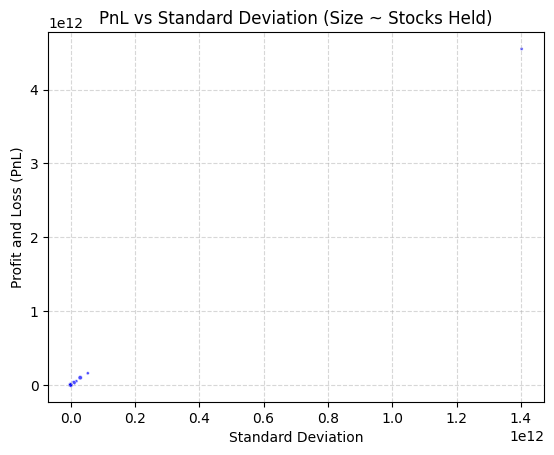

In [7]:
view = a.copy()
plt.scatter(view["std"], view["pnl"], s=view["num_stocks"]*10, color=view["color"], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.xlabel("Standard Deviation")
plt.ylabel("Profit and Loss (PnL)")
plt.title("PnL vs Standard Deviation (Size ~ Stocks Held)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

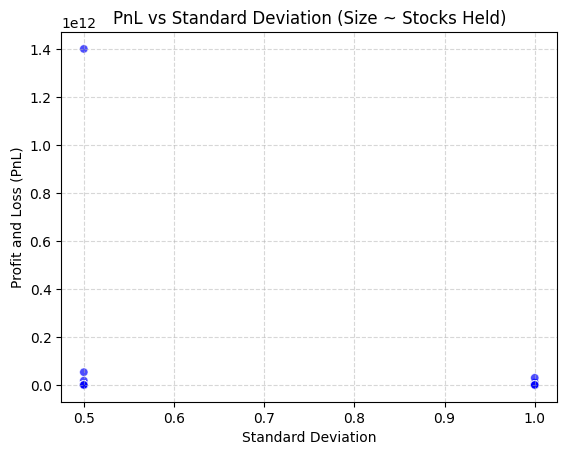

In [8]:
plt.scatter(view["num_stocks"], view["std"],color=view["color"], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.xlabel("Standard Deviation")
plt.ylabel("Profit and Loss (PnL)")
plt.title("PnL vs Standard Deviation (Size ~ Stocks Held)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [9]:
chung.connect()
product = chung.retrieve("sim")
chung.disconnect()
product = p.column_date_processing(product).sort_values("date")

In [13]:
top = a.sort_values("pnl",ascending=False).iloc[0].to_dict()
results,trades,portfolio = Backtester.run_strategy(product[product["date"]>datetime(2008,1,1,tzinfo=timezone.utc)],top,spy)

In [23]:
top

{'stoploss': 0,
 'filter_rate': 0.05,
 'signal': 'ema',
 'ascending': False,
 'direction': 1,
 'market_cap_ceiling': 1,
 'market_cap_floor': 0.7,
 'num_stocks': 0.5,
 'pnl': 4551191648635.377,
 'outperformance_ratio': 3.2453544874958506,
 'date': Timestamp('2025-03-21 00:00:00'),
 'downside': 0.582191098034018,
 'coev': 0.14746833615864996,
 'std': 1402371194321.517,
 'average_gain': 1.1217980808494412,
 'average_loss': 0.898976322380431,
 'w/l': 0.6114047287899861,
 'weekly_return': 1.035210599185684,
 'value': 22.007127577573133,
 'color': 'blue'}

In [14]:
m = pd.DataFrame([results])
m[['pnl',
 'downside',
 'coev',
 'std',
 'average_gain',
 'average_loss',
 'w/l',
 'weekly_return',
 'outperformance_ratio']]

,pnl,downside,coev,std,average_gain,average_loss,w/l,weekly_return,outperformance_ratio
0,4.551192e+12,0.582191,0.147468,1.402371e+12,1.121798,0.898976,0.611405,1.035211,3.245354


In [15]:
trades = trades.merge(index[["ticker","name"]],on="ticker",how="left")
trades["count"] = 1

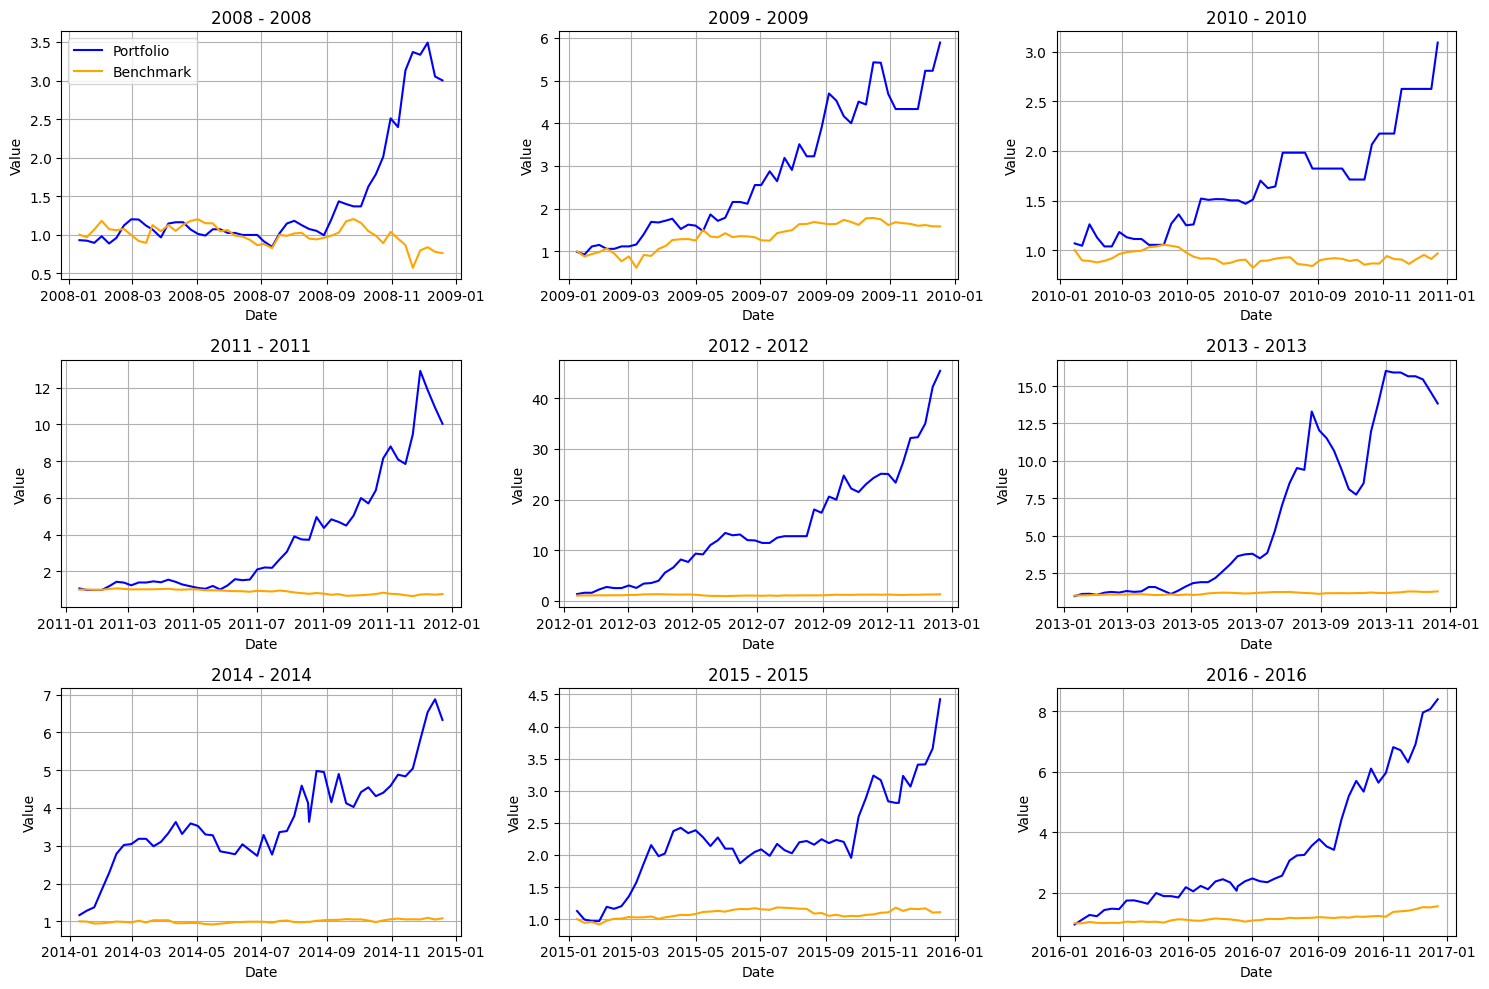

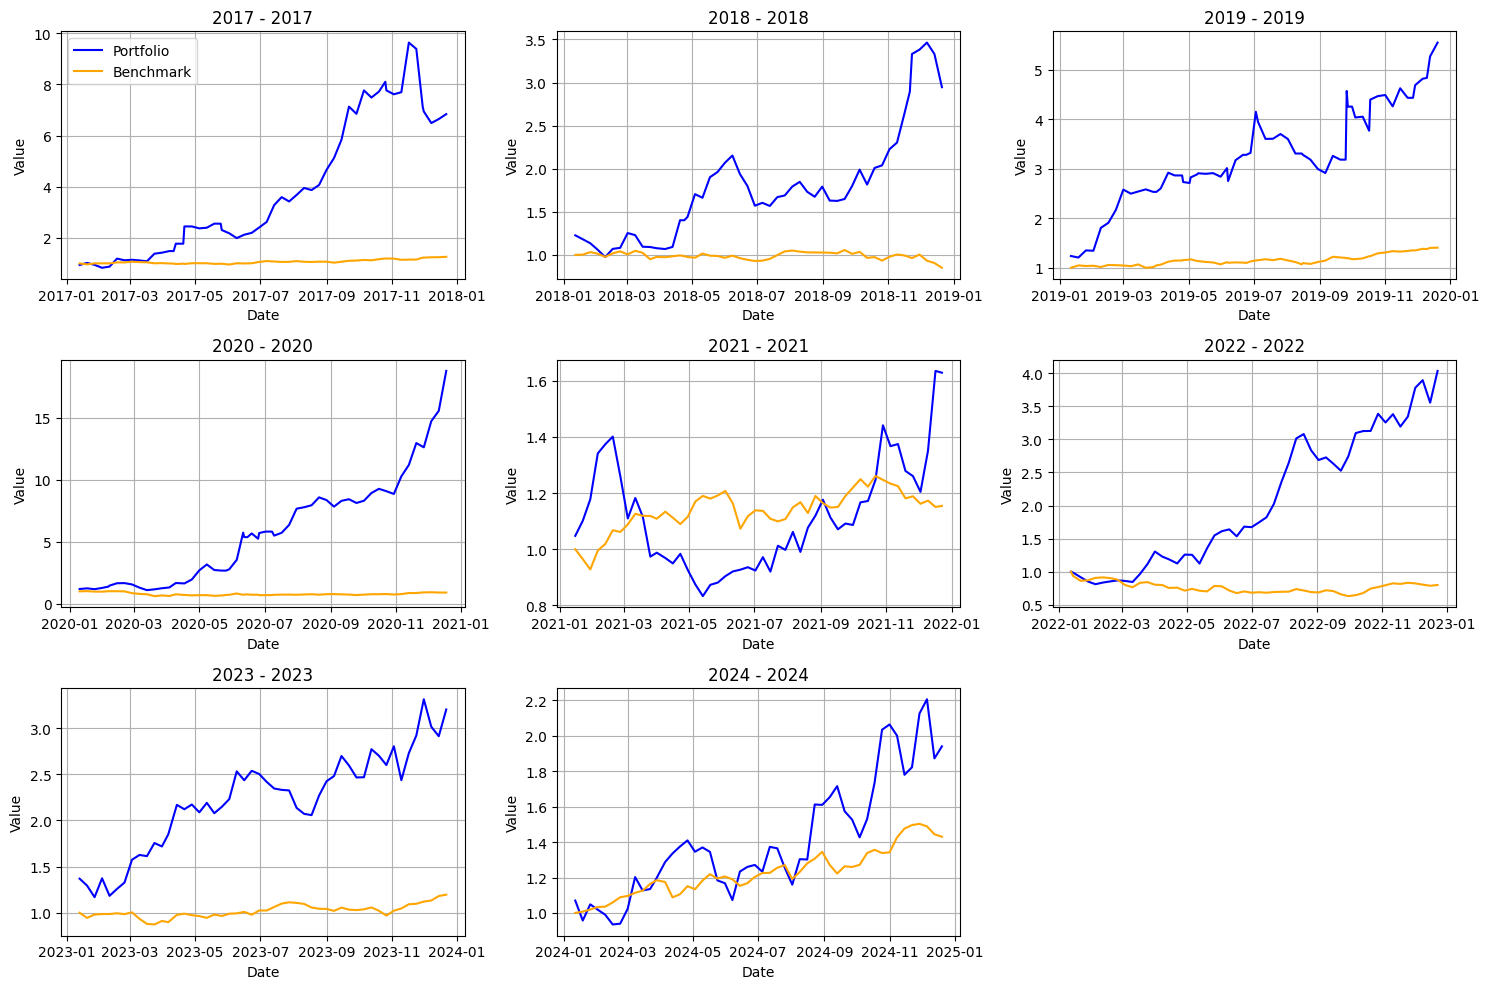

In [17]:
start_year = portfolio["date"].dt.year.min()
end_year = portfolio["date"].dt.year.max()

# Generate 7-year intervals (correcting to 7 years instead of 4)
intervals = list(range(start_year, end_year + 1, 1))

# Setup subplot grid parameters
n_rows, n_cols = 3, 3
plots_per_fig = n_rows * n_cols
num_cycles = len(intervals) - 1

for fig_idx in range(0, num_cycles, plots_per_fig):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten to 1D for easy indexing
    
    for subplot_idx in range(plots_per_fig):
        cycle_idx = fig_idx + subplot_idx
        if cycle_idx >= num_cycles:
            axes[subplot_idx].axis('off')  # Turn off unused subplots
            continue

        start = pd.Timestamp(f"{intervals[cycle_idx]}-01-01",tzinfo=timezone.utc)
        end = pd.Timestamp(f"{intervals[cycle_idx + 1]}-01-01",tzinfo=timezone.utc)
        
        cycle_data = portfolio[(portfolio["date"] >= start) & (portfolio["date"] < end)].copy()
        cycle_data["pv"] = cycle_data["return"].cumprod()
        cycle_data["benchmark_pnl"] = cycle_data["benchmark"] / cycle_data["benchmark"].iloc[0]
        if not cycle_data.empty:
            ax = axes[subplot_idx]
            ax.plot(cycle_data["date"], cycle_data["pv"], label="Portfolio", color='blue')
            ax.plot(cycle_data["date"], cycle_data["benchmark_pnl"], label="Benchmark", color='orange')
            ax.set_title(f"{start.year} - {end.year - 1}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Value")
            ax.grid(True)
        else:
            axes[subplot_idx].axis('off')
    
    # Only add legend to first subplot
    axes[0].legend()
    plt.tight_layout()
    plt.show()

In [18]:
trades[["date","name","ticker","adjclose","sell_price","return"]].sort_values("return",ascending=False).iloc[[0,1,2,3,4,5,-5,-4,-3,-2,-1]]

,date,name,ticker,adjclose,sell_price,return
3663,2015-12-18 00:00:00+00:00,InvenTrust Properties Corp.,IVT,0.000627,1.800090,1.620690
3526,2020-04-09 00:00:00+00:00,Borr Drilling Limited,BORR,1.501534,2.984062,1.620690
3536,2016-04-29 00:00:00+00:00,"ABVC BioPharma, Inc. Common Stock",ABVC,180.000000,360.000000,1.620690
3535,2009-01-23 00:00:00+00:00,"Precision Optics Corporation, Inc. Common Stock",POCI,0.200000,0.400000,1.620690
3534,2009-05-15 00:00:00+00:00,Aspira Women's Health Inc. Common Stock,AWH,0.900000,1.800000,1.620690
3533,2008-07-25 00:00:00+00:00,"Comstock Holding Companies, Inc. Class A",CHCI,0.700000,1.400000,1.620690
126,2020-03-13 00:00:00+00:00,"Nine Energy Service, Inc.",NINE,1.360000,0.950000,0.758166
125,2019-03-15 00:00:00+00:00,Datasea Inc. Common Stock,DTSS,49.995000,34.875000,0.758166
124,2023-07-07 00:00:00+00:00,"Fresh Vine Wine, Inc.",VINE,0.580000,0.402000,0.758166
123,2017-05-26 00:00:00+00:00,"Golden Matrix Group, Inc. Common Stock",GMGI,0.195000,0.135000,0.758166


In [19]:
trades[["date","name","ticker","adjclose","sell_price","return"]].sort_values("date",ascending=False).head(50)

,date,name,ticker,adjclose,sell_price,return
2729,2025-03-21 00:00:00+00:00,"ReShape Lifesciences, Inc. Common Stock",RSLS,0.6300,0.664000,1.053968
353,2025-03-21 00:00:00+00:00,Icon Energy Corp. Common stock,ICON,0.1080,0.091000,0.842593
688,2025-03-21 00:00:00+00:00,"Digital Ally, Inc. Common Stock",DGLY,0.0732,0.067000,0.915301
738,2025-03-21 00:00:00+00:00,Baijiayun Group Ltd. Class A Ordinary Shares,RTC,0.3408,0.315000,0.924296
2747,2025-03-21 00:00:00+00:00,"Scorpius Holdings, Inc.",SCPX,0.1570,0.166000,1.057325
1322,2025-03-21 00:00:00+00:00,"Aspire Biopharma Holdings, Inc. Common Stock",ASBP,0.6369,0.630400,0.989794
3074,2025-03-21 00:00:00+00:00,UTime Limited Ordinary Shares,WTO,0.2075,0.236900,1.141687
561,2025-03-14 00:00:00+00:00,UTime Limited Ordinary Shares,WTO,0.2120,0.189315,0.892995
358,2025-03-14 00:00:00+00:00,Baijiayun Group Ltd. Class A Ordinary Shares,RTC,0.3500,0.295800,0.845143
3036,2025-03-14 00:00:00+00:00,"Digital Ally, Inc. Common Stock",DGLY,0.0700,0.078800,1.125714


In [20]:
trades.groupby(["name","ticker"]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values("count",ascending=False).head(20)

,,return,coev,count,adjclose,market_cap
name,ticker,,,,,
ACCESS Newswire Inc.,ACCS,1.140485,0.590689,132,4.089399,5.741050e+04
"Nixxy, Inc. Common Stock",NIXX,1.028589,1.130280,103,138.451456,2.072002e+05
"Giftify, Inc. Common Stock",GIFT,1.096448,0.582509,66,1.601173,1.111227e+05
"Flux Power Holdings, Inc. Common Stock",FLUX,1.038441,0.893220,58,0.490500,2.179276e+04
AppTech Payments Corp. Common Stock,APCX,1.122730,0.542699,56,0.184464,2.027532e+04
"Modular Medical, Inc. Common Stock",MODD,1.022865,0.670862,55,0.853636,1.176998e+04
"Kaival Brands Innovations Group, Inc",KAVL,1.035080,0.545987,49,8.954229,1.772448e+05
"The OLB Group, Inc. Common Stock",OLB,0.996179,0.501461,47,34.394872,7.160172e+04
"ABVC BioPharma, Inc. Common Stock",ABVC,1.093575,0.549850,45,69.616443,1.373833e+05


In [21]:
trades.groupby(["date"]).agg({"return":"mean","coev":"mean","count":"sum","adjclose":"mean","market_cap":"mean"}).sort_values("return",ascending=True).head(20)

,return,coev,count,adjclose,market_cap
date,,,,,
2017-11-30 00:00:00+00:00,0.758166,0.161392,1,0.170000,2.492852e+05
2011-05-27 00:00:00+00:00,0.818625,0.434579,4,7.877297,9.552566e+04
2020-03-06 00:00:00+00:00,0.834395,0.242916,5,13.155784,4.554690e+05
2012-03-09 00:00:00+00:00,0.838777,0.595932,3,1.318815,3.054176e+04
2014-09-05 00:00:00+00:00,0.838777,0.348752,3,2.185333,2.272463e+04
2013-04-05 00:00:00+00:00,0.838777,0.487328,3,130.684000,1.496122e+05
2013-04-12 00:00:00+00:00,0.838777,0.525871,3,87.350667,1.561188e+05
2014-07-11 00:00:00+00:00,0.841730,0.425194,3,3.611000,5.464360e+05
2014-09-19 00:00:00+00:00,0.842038,0.422852,3,1.865333,2.392061e+04


In [22]:
portfolio["diff"] = portfolio["pnl"].pct_change()
portfolio.sort_values("diff",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,diff
649,2020-06-11 00:00:00+00:00,1.620690,5.208821e+10,85.121539,3.214890,0.620690
607,2019-09-26 00:00:00+00:00,1.435897,7.476069e+09,99.934114,3.774335,0.435897
203,2012-02-03 00:00:00+00:00,1.425690,1.220817e+03,26.769062,1.011020,0.425690
283,2013-08-23 00:00:00+00:00,1.415268,3.315852e+05,38.174668,1.441790,0.415268
232,2012-08-24 00:00:00+00:00,1.413793,9.889236e+03,26.383293,0.996450,0.413793
291,2013-10-18 00:00:00+00:00,1.406476,2.981783e+05,39.908378,1.507269,0.406476
212,2012-04-05 00:00:00+00:00,1.405460,3.027687e+03,31.211598,1.178807,0.405460
470,2017-04-21 00:00:00+00:00,1.380808,1.986030e+08,68.217744,2.576463,0.380808
642,2020-05-01 00:00:00+00:00,1.377574,2.447692e+10,81.653981,3.083926,0.377574
278,2013-07-19 00:00:00+00:00,1.373563,1.317808e+05,40.976479,1.547609,0.373563
